In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu121
False


## Chuẩn bị dữ liệu

Bài toán phân loại ảnh trang phục hàng ngày, sử dụng bộ dữ liệu Fashion MNIST. Bộ dữ liệu này tương tự MNIST gồm các ảnh đen trắng (grayscale) kích thước $28 \times 28$, với giá trị pixel nằm trong đoạn $[0, 1]$. Mỗi ảnh tương ứng với ảnh của một trong 10 loại trang phục.

Bộ dữ liệu gồm 70000 ảnh đã được gán nhãn, được chia thành hai tập dữ liệu: training gồm 60000 ảnh và testing gồm 10000 còn lại.

In [3]:
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor())
test_data  = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor())

100%|██████████| 26421880/26421880 [00:12<00:00, 2095497.57it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200453.85it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:07<00:00, 561628.99it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4821857.30it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



torch.Size([1, 28, 28])
Train data size = 60000
Test  data size = 10000
Input size = torch.Size([1, 28, 28])


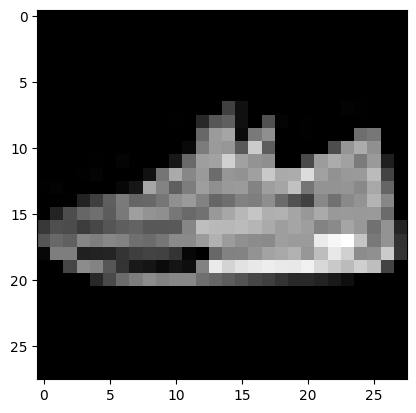

In [4]:
print(train_data[0][0].shape)
print(f"Train data size = {len(train_data)}")
print(f"Test  data size = {len(test_data)}")
print(f"Input size = {train_data[0][0].shape}")
plt.imshow(train_data[1023][0][0,:,:], cmap='gray', vmin=0.0, vmax=1.0)

## Xây dựng mô hình học

Sử dụng mô hình học có tham số, với các tham số được ký hiệu là $\theta$. Trong bài toán học phân loại này, cần xác định hàm ánh xạ $f_\theta: \mathbf{X} ↦ y$, với $\mathbf{X}$ là ma trận ảnh và $y$ là nhãn ảnh. Để xác định hàm ánh xạ đó, phương pháp học máy này cần xác định, tối ưu tham số $\theta$ của mô hình. Việc tối ưu đó dựa trên mục tiêu **tối thiểu** giá trị của hàm loss đánh giá khả năng phân loại của mô hình.

Với bài toán phân loại, hàm loss phổ biến được dùng là hàm *cross-entropy*, đo mức độ tương quan giữa hai phân phối. Ở đây, hàm $f_\theta$ với đầu vào là ảnh $\mathbf{X}$ sẽ cho ra một phân phối đa thức của 10 nhãn, nhãn nào có giá trị xác suất cao nhất sẽ là đầu ra $y$ của mô hình. Ví dụ bài toán chỉ yêu cầu phân loại ra 3 nhãn, với đầu vào $\mathbf{X}$ được gán nhãn là 2, $f_\theta$ cho ra phân phối $q=[0.2, 0.7, 0.1]$, do $\mathbf{X}$ được gán nhãn 2 nên phân phối lý tưởng đầu ra là $p=[0, 1, 0]$, khi đó hàm loss sẽ là độ lệch, sai khác giữa hai phân phối $p$ và $q$. Độ đo cross-entroy thực hiện đo thông qua công thức Kullback-Leibler $$D_{KL}(p(X) \| q(X)) = \sum_{x \in \mathcal{X}}{p(x)\log\frac{p(x)}{q(x)}}=\sum_{i=1}^k{p_i\log\frac{p_i}{q_i}}$$

Vậy nên, hàm loss ứng với ảnh đầu vào $\mathbf{X}$ có nhãn $c$ sẽ bằng $\mathcal{L} = \log\dfrac{1}{q_c}$, với $q_c$ là xác suất ảnh có nhãn $c$ trong phân phối đa thức đầu ra của hàm $f_\theta$.


Sử dụng mô hình mạng neural fully-connected đơn giản sử dụng activation function ReLU cho việc phân loại bài toán này.

#### Xây dựng lớp mô hình mạng

Tạo một lớp mô hình kế thừa từ lớp mô hình `nn.Module` từ thư viện PyTorch. Để xây dựng mạng fully-connected đơn giản, layer đầu tiên thực hiện đưa ma trận ảnh về dạng một chuỗi vector. Tiếp theo đó là `num_hidden` layer ẩn có số chiều là `d_hidden` với activation function là ReLU. Sau đó tẩng ẩn cuối cùng là tầng output. Để đầu ra của mô hình mạng là một phân phối đa thức multinomial thì sau tầng output thêm một tầng Softmax để thực hiện chuẩn hóa thành phân phối.

In [5]:
class MyClassify(nn.Module):
  def __init__(self, d_in, d_out, num_hidden, d_hidden):
    super(MyClassify, self).__init__()

    layers = [] # danh sách các layers trong mô hình mạng
    layers.append( nn.Flatten() ) # duỗi ma trận ảnh đầu vào thành vector

    layers.append( nn.Linear(d_in, d_hidden) ) # nối fully-connected giữa tầng đầu vào với tầng mạng đầu tiên
    layers.append( nn.ReLU() ) # activation function ReLU

    for i in range(1, num_hidden):
      layers.append( nn.Linear(d_hidden, d_hidden) ) # nối fully-connected các tẩng ẩn với nhau
      layers.append( nn.ReLU() )

    layers.append( nn.Linear(d_hidden, d_out) ) # nối fully-connected giữa tầng ẩn và tầng output cuối
    layers.append( nn.Softmax() ) # nối tầng output cuối với một layer softmax để output là một phân phối đa thức multinomial

    self.network = nn.Sequential(*layers)

  def forward(self, x):
    return self.network(x)



In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#### Huấn luyện mô hình

Sử dụng mô hình mạng neural fully-connected layer với 2 tầng ẩn, mỗi tẩng ẩn là một vector 512 chiều. Phương pháp tối ưu tham số được sử dụng là stochastic gradient descent (SGD) với tham số học `lr` (learning rate) bằng $10^{-3}$.

Sau khi được huấn luyện 10 epochs, hiệu năng của mô hình huấn luyện trên tập testing là $> 60\%$.

In [7]:
def training(model, optimizer, loss_fn, data):
  for i, (X, y) in enumerate(data):
    # Foward
    predict = model(X)
    target = torch.zeros_like(predict)
    target[torch.arange(y.shape[0]),y] = 1

    loss = loss_fn(predict, target)

    # Back-propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
      print(f"loss = {loss:.5f} [{i:4d}/{len(data)}]")

@torch.no_grad()
def evaluation(model, data):
  acc = 0
  N = 0
  for i, (X, y) in enumerate(data):
    predict = torch.argmax(model(X), dim=1)
    acc += (predict == y).sum().item()
    N += len(y)
  acc /= N
  acc *= 100.0
  print(f"Accuracy = {acc:.2f}%")

In [8]:
# Hyper-parameters
batch_size = 2**7
num_epochs = 10
lr = 1e-2
d_in = 28*28
d_out = 10
num_hidden = 2
d_hidden = 512

train = DataLoader(train_data, batch_size=batch_size, shuffle=True) # chia bộ dữ liệu ra thành các batch có kích thước bằng batch_size
test = DataLoader(test_data, batch_size=batch_size)

model = MyClassify(d_in, d_out, num_hidden, d_hidden).to(device)
loss_fn = nn.CrossEntropyLoss() # hàm loss cross-entropy
optimizer = torch.optim.SGD(model.parameters(), lr=lr) # tối ưu tham số trong mô hình bằng thuật toán stochastic graident descent (SGD)

for epoch in range(num_epochs):
  training(model, optimizer, loss_fn, train)
  evaluation(model, test)

loss = 2.30347 [   0/469]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


loss = 2.30230 [ 100/469]
loss = 2.30063 [ 200/469]
loss = 2.29824 [ 300/469]
loss = 2.29725 [ 400/469]
Accuracy = 15.37%
loss = 2.29668 [   0/469]
loss = 2.29494 [ 100/469]
loss = 2.29195 [ 200/469]
loss = 2.28886 [ 300/469]
loss = 2.28535 [ 400/469]
Accuracy = 22.51%
loss = 2.28204 [   0/469]
loss = 2.27830 [ 100/469]
loss = 2.27737 [ 200/469]
loss = 2.27229 [ 300/469]
loss = 2.26555 [ 400/469]
Accuracy = 24.79%
loss = 2.25445 [   0/469]
loss = 2.24810 [ 100/469]
loss = 2.22811 [ 200/469]
loss = 2.23684 [ 300/469]
loss = 2.19434 [ 400/469]
Accuracy = 36.04%
loss = 2.12665 [   0/469]
loss = 2.18510 [ 100/469]
loss = 2.17100 [ 200/469]
loss = 2.15438 [ 300/469]
loss = 2.10001 [ 400/469]
Accuracy = 41.31%
loss = 2.14394 [   0/469]
loss = 2.07945 [ 100/469]
loss = 2.04337 [ 200/469]
loss = 2.00164 [ 300/469]
loss = 2.02442 [ 400/469]
Accuracy = 61.10%
loss = 1.97707 [   0/469]
loss = 1.99245 [ 100/469]
loss = 1.90352 [ 200/469]
loss = 1.91700 [ 300/469]
loss = 1.87194 [ 400/469]
Accuracy

In [9]:
evaluation(model, test)

Accuracy = 67.38%


#### Inference

Lấy ngẫu nhiên một ảnh từ tập testing đưa vào cho mô hình đã huấn luyện phân loại ảnh

Predict : Dress
Expected: Dress


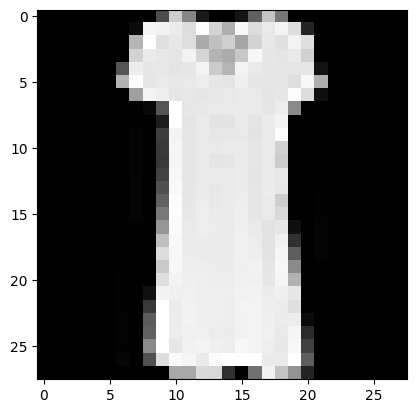

In [10]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
    }

M = len(test_data)
idx = torch.randint(0, M, (1,)).item()
X = test_data[idx][0]
actual_class = test_data[idx][1]

with torch.no_grad():
  predict = model(X)
  predict_class = torch.argmax(predict).item()

print(f"Predict : {labels_map[predict_class]}")
print(f"Expected: {labels_map[actual_class]}")
plt.imshow(X[0], cmap='gray', vmin=0., vmax=1.)